You can download Land-Use Scene Classification dataset [here](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification).
The first step is to prepare the dataset in the pytorch Dataset format.

In [1]:
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder

dataset_path = '/media/n31v/data/datasets/Land-Use_Scene_Classification/images_train_test_val/'

transform = Compose([ToTensor(), Resize((256, 256))])
train_dataset = ImageFolder(root=dataset_path + 'train', transform=transform)
val_dataset = ImageFolder(root=dataset_path + 'validation', transform=transform)

In the cell below, we define the parameters of the experiments to be carried out: an experiment without structure optimization, experiments with a singular value decomposition of convolutional layers, and experiments with soft filter pruning.

If you want to use a pre-trained model, you can set weights parameter like `weights=<your path to state dict>`.

If you don't want to reproduce experiments, you can skip this cell.

In [ ]:
energy_thresholds = [
    0.1, 0.3, 0.5, 0.7, 0.9,
    0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
    0.992, 0.994, 0.996, 0.998, 0.999,
    0.9999, 1
]
optimizations = {
    'none': [{}],
    'SVD': [
        {
            'decomposing_mode': 'spatial',
            'orthogonal_loss_factor': 10,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
        {
            'decomposing_mode': 'channel',
            'orthogonal_loss_factor': 10,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
        {
            'decomposing_mode': 'spatial',
            'orthogonal_loss_factor': 100,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
        {
            'decomposing_mode': 'channel',
            'orthogonal_loss_factor': 100,
            'hoer_loss_factor': 0.001,
            'energy_thresholds': energy_thresholds,
            'finetuning_epochs': 5
        },
    ],
    'SFP': [
        {
            'pruning_ratio': 0.5,
            'finetuning_epochs': 5
        },
        {
            'pruning_ratio': 0.7,
            'finetuning_epochs': 5
        },
        {
            'pruning_ratio': 0.8,
            'finetuning_epochs': 5
        },
        {
            'pruning_ratio': 0.9,
            'finetuning_epochs': 5
        },
    ]
}

In the cell below, we run experiments for 100 epochs.

If you do not want to reproduce experiments, you can skip this cell.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import warnings
warnings.filterwarnings("ignore")

import torch
from core.operation.utils.cv_experimenters import ClassificationExperimenter


for optimization, params_list in optimizations.items():
    for params in params_list:
        experimenter = ClassificationExperimenter(
            dataset_name='Land-Use_Scene_Classification',
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            num_classes=21,
            dataloader_params={'batch_size': 32, 'num_workers': 4},
            model='ResNet18',
            model_params={},
            models_saving_path='models',
            optimizer=torch.optim.Adam,
            optimizer_params={},
            target_loss=torch.nn.CrossEntropyLoss,
            loss_params={},
            target_metric='f1',
            structure_optimization=optimization,
            structure_optimization_params=params,
            summary_path='runs',
            summary_per_class=True,
            gpu=True
        )
        experimenter.fit(100)

If you want to use our trained model, you can use the code from the cell below.

In [9]:
import torch
from core.operation.utils.cv_experimenters import ClassificationExperimenter

optimization_params = {
    'decomposing_mode': 'spatial',
    'orthogonal_loss_factor': 10,
    'hoer_loss_factor': 0.001,
    'energy_thresholds': [],
    'finetuning_epochs': 0
}

experimenter = ClassificationExperimenter(
    dataset_name='Land-Use_Scene_Classification',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_classes=21,
    dataloader_params={'batch_size': 32, 'num_workers': 4},
    model='ResNet18',
    model_params={},
    models_saving_path='models',
    optimizer=torch.optim.Adam,
    optimizer_params={},
    target_loss=torch.nn.CrossEntropyLoss,
    loss_params={},
    target_metric='f1',
    structure_optimization='SVD',
    structure_optimization_params=optimization_params,
    summary_path='runs',
    summary_per_class=True,
    gpu=True
)
experimenter.load_model('fine-tuned_e_0.99')
scores = experimenter.val_loop()
for k, v in scores.items():
    print(f'{k}: {v:.3f}')

Default size: 44.79 MB
SVD decomposed size: 86.02 MB
Model loaded.


100%|██████████| 66/66 [00:02<00:00, 26.87it/s]


loss: 0.313
inference_time: 0.037
accuracy: 0.913
precision: 0.915
recall: 0.913
f1: 0.913
roc_auc: 0.997
f1_class0: 0.990
f1_class1: 0.980
f1_class2: 0.922
f1_class3: 0.946
f1_class4: 0.789
f1_class5: 1.000
f1_class6: 0.806
f1_class7: 0.985
f1_class8: 0.898
f1_class9: 0.949
f1_class10: 0.990
f1_class11: 0.847
f1_class12: 0.765
f1_class13: 0.893
f1_class14: 0.887
f1_class15: 0.990
f1_class16: 0.943
f1_class17: 0.956
f1_class18: 0.836
f1_class19: 0.823
f1_class20: 0.980


Top models by f1 metric.

In [13]:
from visualization_utils import parse_experiment_folder

train_scores, svd_scores, sfp_scores = parse_experiment_folder('runs/Land-Use_Scene_Classification')
train_scores['val/f1'].max(axis=0).sort_values(ascending=False)

ResNet18                                   0.934703
ResNet18_SFP_P-0.50                        0.929713
ResNet18_SVD_spatial_O-100.0_H-0.001000    0.911742
ResNet18_SFP_P-0.70                        0.907076
ResNet18_SVD_spatial_O-10.0_H-0.001000     0.900310
ResNet18_SVD_channel_O-100.0_H-0.001000    0.897529
ResNet18_SVD_channel_O-10.0_H-0.001000     0.895134
ResNet18_SFP_P-0.80                        0.866985
ResNet18_SFP_P-0.90                        0.150773
dtype: float64

Run the next cell to visualize the results.

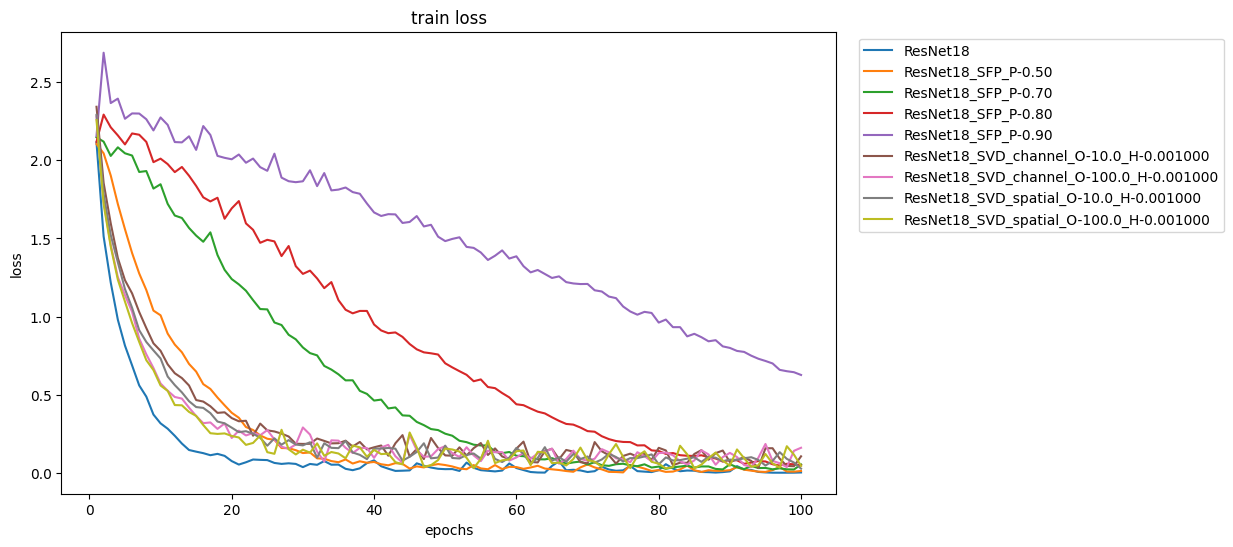

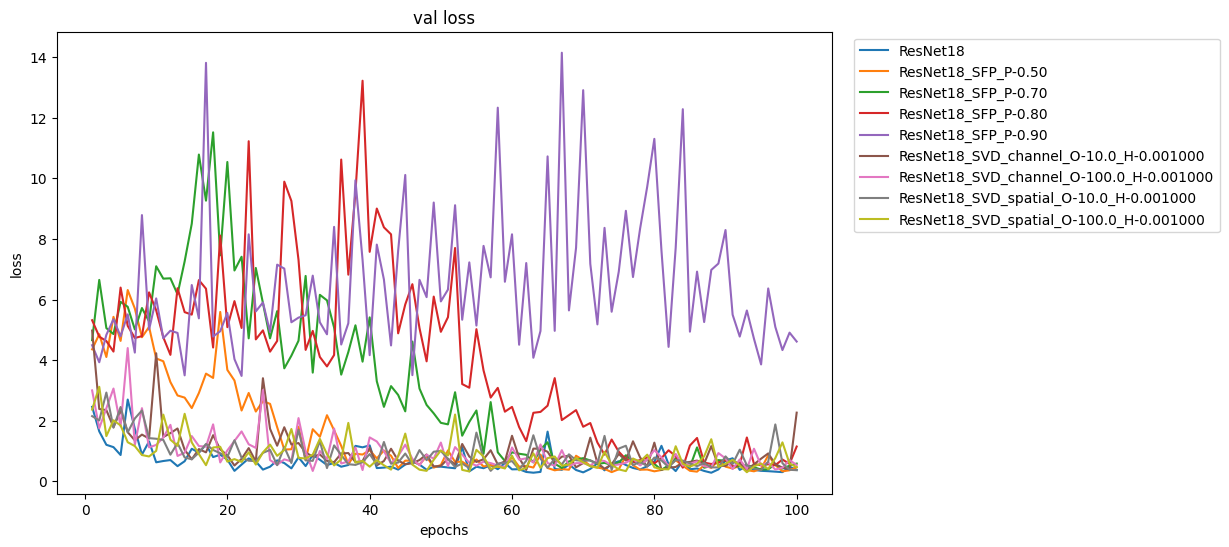

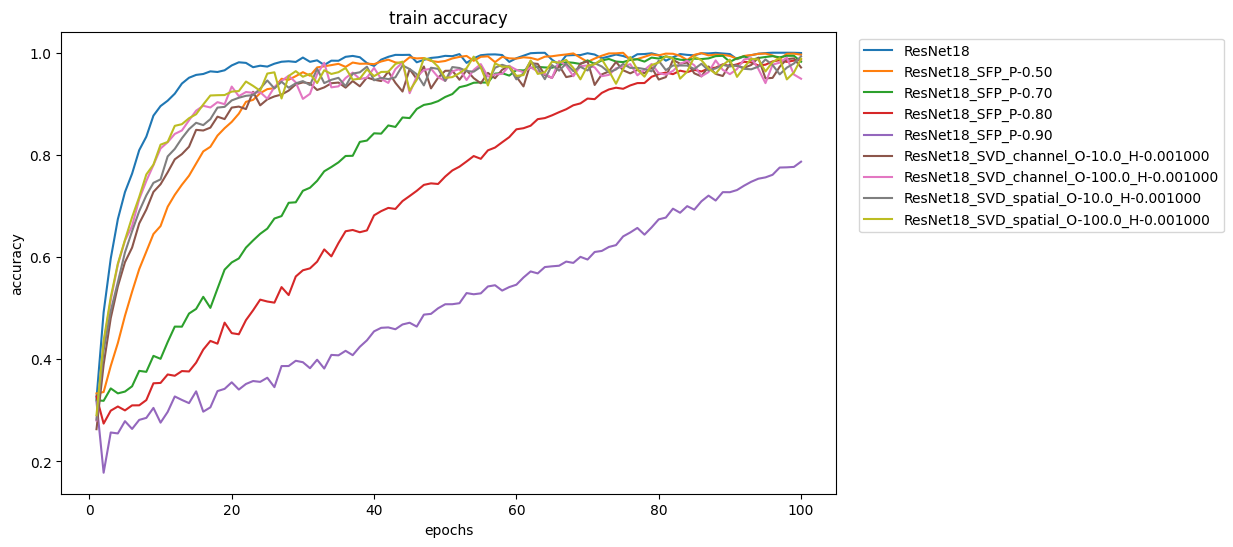

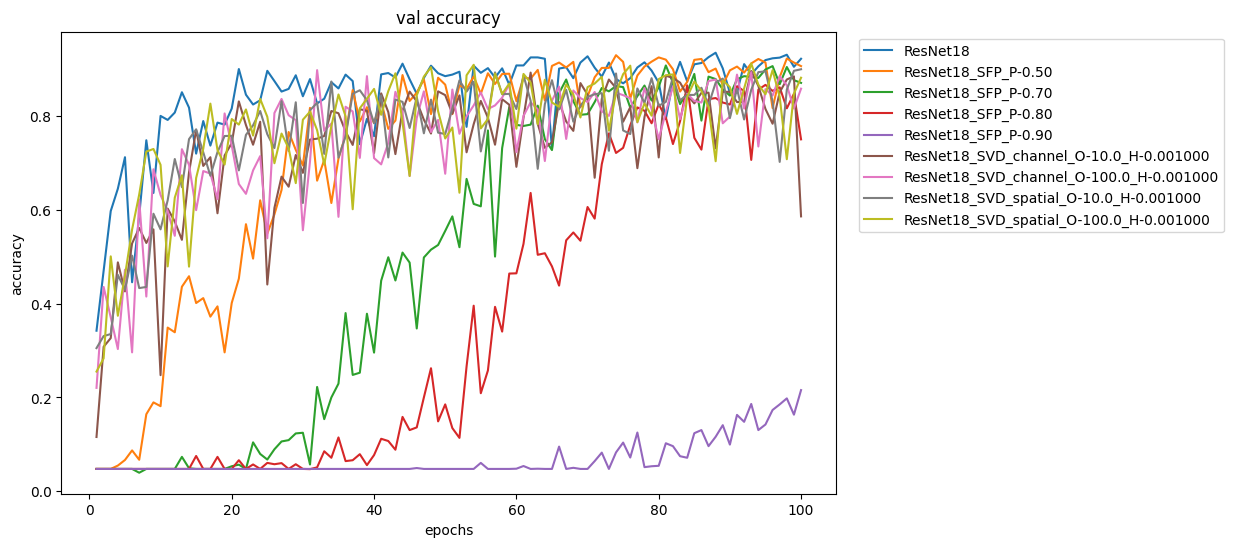

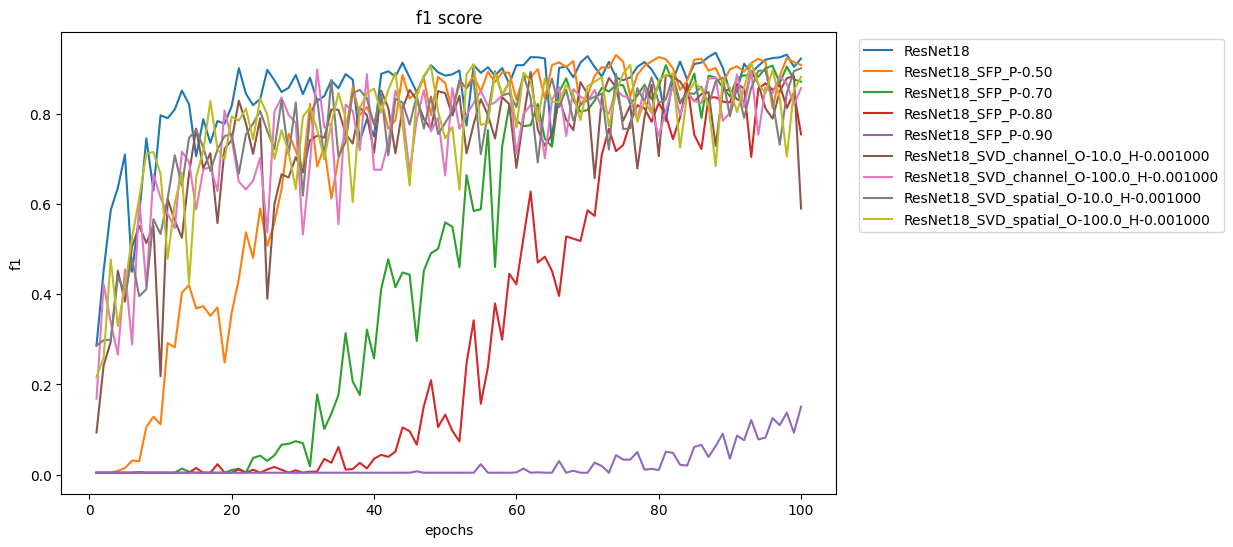

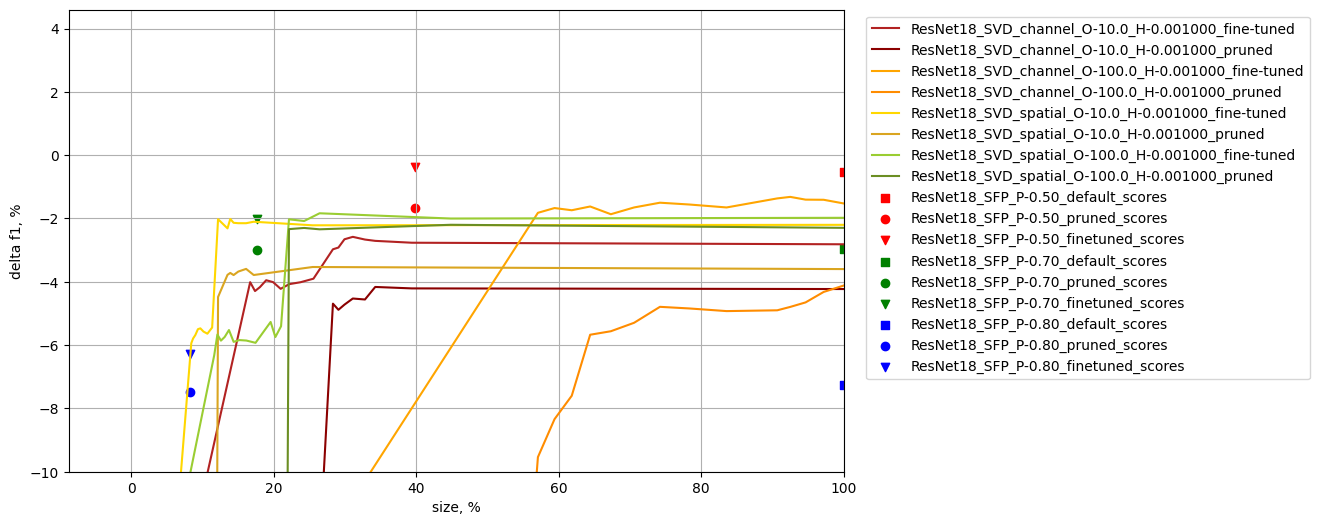

In [14]:
from visualization_utils import draw_results

draw_results('runs/Land-Use_Scene_Classification', baseline='ResNet18', min_y=-10, max_x=100)